<div style="width: 100%; text-align: center;">
    <div style="background-color:#007F00; padding: 0.5rem;">
        <h1 style="font-weight: bold; font-size: 2.5em; color: black;"> AGRHYMET CENTRE CLIMATIQUE REGIONAL POUR L'AFRIQUE DE L'OUEST ET LE SAHEL</h1>
   </div>

   <div style="text-align: center;">
  <img src="https://www.sareco.org/wp-content/uploads/2017/07/plrDvYX1.jpg" width="200">
</div>

<a id="1"></a>
# <p style="padding:10px;background-color:#FFFFFF ;margin:0;color:#007F00;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Capacity Building in Seasonal Hydrological Forecasting </p>

<a id="1"></a>
### <p style="padding:10px;background-color:#000000 ;margin:0;color:#007F00;font-family:#newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Seasonal Hydrologic Forecasts with WASS2SHydroR (Statistical Method) </p>

## 1) PARAMETERS (participants only edit this block)

In [2]:
"BEN" "GMB" "GHA" "GIN" "CIV" "LBR" "MLI" "MRT" "NER" "NGA" "GNB" "SEN" "SLE" "TGO" "BFA" "TCD" "CPV"

ERROR: Error in parse(text = input): <text>:1:7: unexpected string constant
1: "BEN" "GMB"
          ^


In [ ]:
# ---- Dependencies ----------------------------------------------------------
.libPaths('C:/Users/ARSENE/.local/share/mamba/envs/wass2s-hydro-3/Lib/R/library')
setwd("D:/CCR_AOS/Wass2sHydro-Training")
rm(list = ls())
# ==== PARAMETERS (participants only edit this block) ==========================
PATH_INPUTS <- "outputs/SST_training_list_CIV.rds"
data_by_products <- readRDS(PATH_INPUTS)
COUNTRY_CODE <- "CIV" # "BEN" "GMB" "GHA" "GIN" "CIV" "LBR" "MLI" "MRT" "NER" "NGA" "GNB" "SEN" "SLE" "TGO" "BFA" "TCD" "CPV"
PATH_COUNTRIES   <- "static/was_contries.shp"   # shapefile with GMI_CNTRY field
PATH_SUBBASINS   <- "static/subbassins.shp"
PREDICTOR_VARS <-"SST"
PATH_OUTPUT <- "outputs"
FINAL_FUSER <- "rf"
dir.create(PATH_OUTPUT, showWarnings = FALSE)
fyear <- 2025
source("scripts/load_required_packages_frcst.R")

## 2) Run statistical forecasts for each product group

In [3]:
message("Running statistical forecasts (per product) ...")
stats_results <- map2(data_by_products, names(data_by_products), function(.x,.y){
  pred_pattern_by_product <- as.vector(rep("^sst_",length(.x)))
  names(pred_pattern_by_product) <- names(.x)
  frcst <- WASS2SHydroR::wass2s_run_basins_stat(data_by_product = .x,
                                                hybas_id ="HYBAS_ID",
                                                pred_pattern_by_product  = pred_pattern_by_product,
                                                final_fuser = FINAL_FUSER,
                                                grid_levels = 10,
                                                topK = 1,
                                                min_kge_model =0,
                                                prediction_years =c(fyear,fyear),
                                                init_frac = 0.8,
                                                assess_frac = 0.2,
                                                cumulative = TRUE)
  names(frcst) <- .y
  return(frcst)
})

{
  timestamp <- format(Sys.time(), "%Y%m%d_%H%M%S")
  file_path <- file.path(PATH_OUTPUT,paste0(COUNTRY_CODE,"_",PREDICTOR_VARS,"_seasonal_forecast_stat_", FINAL_FUSER, "_",timestamp,".rds"))
  saveRDS(object =stats_results ,file = file_path )
  message("File saved: ", file_path)
}

Running statistical forecasts (per product) ...

Running sequentially

Processing basin: 1040023310

[pcr] CCSM4 : 1281 predictors using pattern '^sst_'

[pcr] CFSv2 : 1281 predictors using pattern '^sst_'

[pcr] CanSIPSIC4 : 1281 predictors using pattern '^sst_'

[pcr] METEOFRANCE9 : 1200 predictors using pattern '^sst_'

[pcr] SEAS51 : 1281 predictors using pattern '^sst_'

[pcr] SPSv3p5 : 1200 predictors using pattern '^sst_'

[pcr] SEAS51c : 1200 predictors using pattern '^sst_'

[ridge] CCSM4 : 1281 predictors using pattern '^sst_'

[ridge] CFSv2 : 1281 predictors using pattern '^sst_'

[ridge] CanSIPSIC4 : 1281 predictors using pattern '^sst_'

[ridge] METEOFRANCE9 : 1200 predictors using pattern '^sst_'

[ridge] SEAS51 : 1281 predictors using pattern '^sst_'

[ridge] SPSv3p5 : 1200 predictors using pattern '^sst_'

[ridge] SEAS51c : 1200 predictors using pattern '^sst_'

[lasso] CCSM4 : 1281 predictors using pattern '^sst_'

→ A | warning: A correlation computation is required, 

## 3) Extract fused predictions per basin into a single tall tibble

In [5]:
#----------------- 3) Extract fused predictions per basin into a single tall tibble--------------------
message("Extracting fused predictions ...")
stats_results2 <- map(names(stats_results), function(id) {
  stats_results[[id]][[id]]
}) %>%
  set_names(names(stats_results))

stat_preds <- map2(stats_results2,names(stats_results2), function(.x,.y){
  fused_by_model <- .x$fused_by_model

  if(!all(c("YYYY","Q" ,"pred_final") %in% names(fused_by_model))){
    fused_by_model <- data.frame()
    return(fused_by_model)
  }
  fused_by_model <- fused_by_model %>%
    dplyr::select("YYYY","Q" ,"pred_final") %>%
    rename(pred = pred_final) %>%
    mutate(HYBAS_ID = .y)
}) %>% bind_rows()

hybas_ids <- unique(stat_preds$HYBAS_ID)

Extracting fused predictions ...



## 4) Compute class probabilities per basin/year

In [7]:
#--------------------- 4) Compute class probabilities per basin/year-----------------------------------
message("Computing class probabilities ...")
probabilities <- map(hybas_ids,~{
  stat_pred <- stat_preds %>%
    dplyr::filter(HYBAS_ID == .x)
  rr <- c(stat_pred$Q-stat_pred$pred)^2

  error_sd <- sd(c(stat_pred$Q-stat_pred$pred),na.rm = TRUE)
  error_rmse <- sqrt(mean(rr,na.rm = TRUE))

  proba <- WASS2SHydroR::wass2s_class_from_forecast(df = stat_pred,
                                                    q_hist = stat_pred$Q,
                                                    sigma =error_sd )
  return(proba)
}) %>% bind_rows()


yprobas <- probabilities %>%
  dplyr::filter(YYYY == fyear) %>%
  mutate(HYBAS_ID = as.factor(HYBAS_ID))

Computing class probabilities ...



## 5) Probability map

Building probability map ...



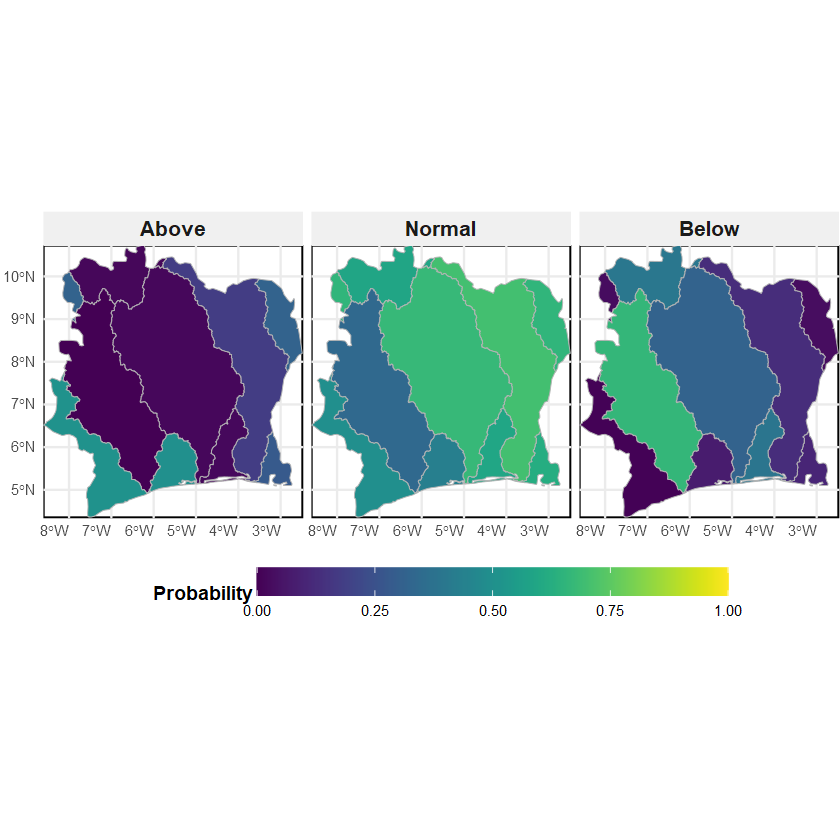

In [8]:
# ---- 5) Probability map -------------------------------------------------------
message("Building probability map ...")
proba_plot <- WASS2SHydroR::wass2s_plot_map(sf_basins =sf_basins,
                                            data = yprobas,basin_col = "HYBAS_ID" )


print(proba_plot)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Probabilities Map saved: CIV_SST_2025_stat_probas_rf_20251019_225937.png



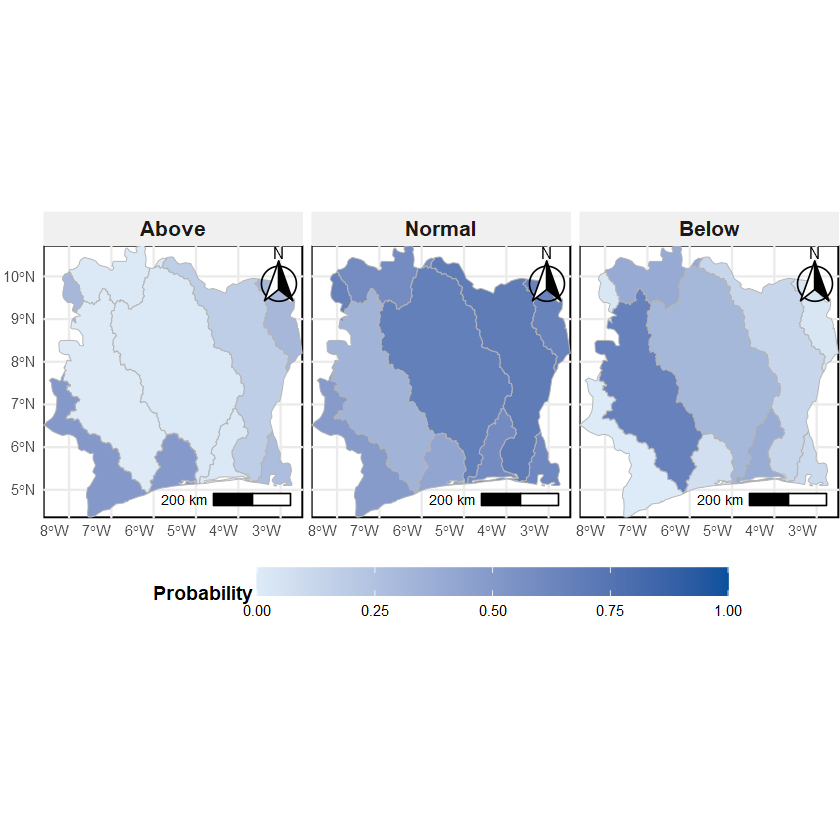

In [9]:
proba_plot <- proba_plot + annotation_north_arrow(
  location = "tr",
  which_north = "true",
  style = north_arrow_fancy_orienteering,
  height = unit(1.2, "cm"),
  width = unit(1.2, "cm"),
  pad_x = unit(-0.1, "cm"),
  pad_y = unit(0.1, "cm")
)+ annotation_scale(
  location = "br",
  width_hint = 0.3
)+
  scale_fill_gradient(
    low = "#deebf7", high = "#08519c",
    name = "Probability",
    limits = c(0, 1)
  )

print(proba_plot)
## Sauvegarder le graphique

{
  timestamp <- format(Sys.time(), "%Y%m%d_%H%M%S")
  filename <- paste0(COUNTRY_CODE, "_", PREDICTOR_VARS,"_",fyear,"_stat_probas_", FINAL_FUSER, "_", timestamp, ".png")
  ggsave(filename = filename,
         plot = proba_plot,
         path = PATH_OUTPUT,
         width = 9.5,
         height = 6.5,
         dpi = 600,
         bg = "white")
  message("Probabilities Map saved: ", filename)
}

## 6) Class map (above/normal/below)

Building class map ...



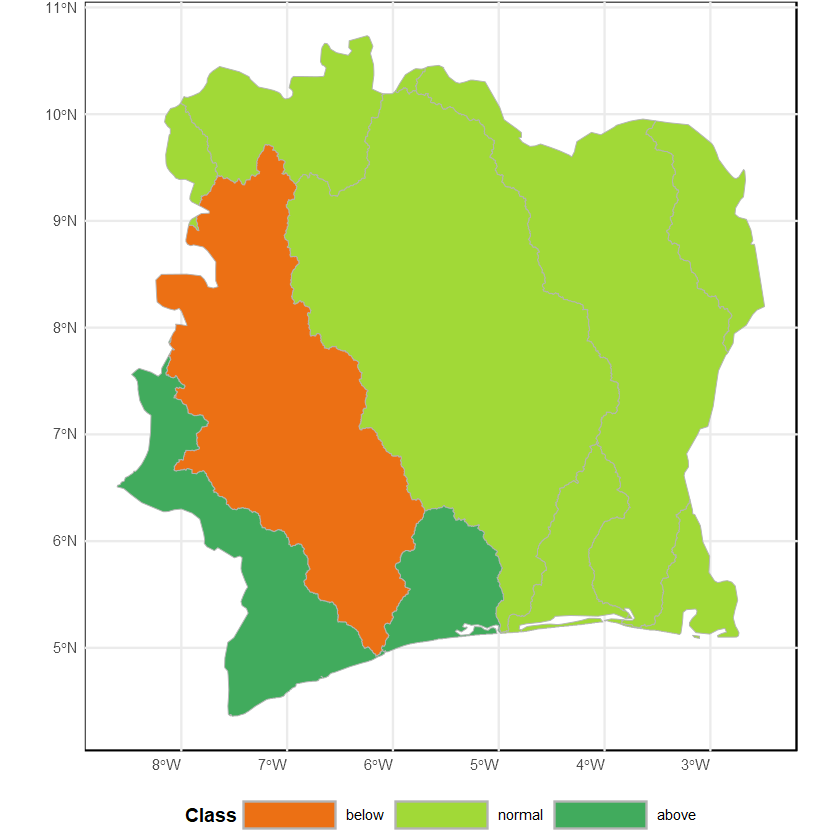

In [11]:
# ---- 6) Class map (above/normal/below) ---------------------------------------
message("Building class map ...")
class_plot <- WASS2SHydroR::wass2s_plot_map(sf_basins =sf_basins,
                                            data = yprobas,
                                            basin_col = "HYBAS_ID",
                                            type = "class")
print(class_plot)


Probabilities Map saved: CIV_SST_2025_stat_class_rf_20251019_230024.png

Done. Outputs saved to: D:/CCR_AOS/Wass2sHydro-Training/outputs



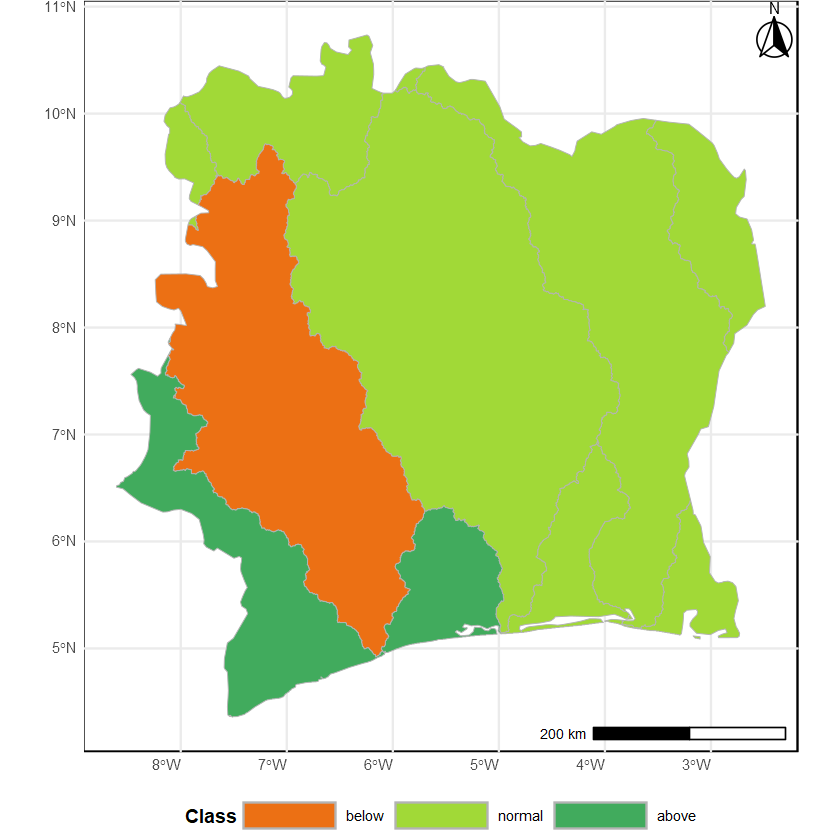

In [12]:
class_plot <- class_plot +
  theme(plot.margin = margin(0.5, 0.5, 0.5, 0.5) )+
  annotation_north_arrow(
    location = "tr",
    which_north = "true",
    style = north_arrow_fancy_orienteering,
    height = unit(1.2, "cm"),
    width = unit(1.2, "cm"),
    pad_x = unit(-0.1, "cm"),
    pad_y = unit(0.1, "cm")
  )+ annotation_scale(
    location = "br",
    width_hint = 0.3
  )

print(class_plot)

## Sauvegarder le graphique

{
  timestamp <- format(Sys.time(), "%Y%m%d_%H%M%S")
  filename <- paste0(COUNTRY_CODE, "_", PREDICTOR_VARS,"_",fyear,"_stat_class_", FINAL_FUSER, "_", timestamp, ".png")
  ggsave(filename = filename,
         plot = class_plot,
         path = PATH_OUTPUT,
         width = 9.5,
         height = 6.5,
         dpi = 600,
         bg = "white")
  message("Probabilities Map saved: ", filename)
}

message("Done. Outputs saved to: ", normalizePath(PATH_OUTPUT, winslash = "/"))